# Corso di Probabilita e Statistica - Esame 24 Gennaio 2025
## Sambruna Alessia

### Consegna
Si consideri il file csv allegato che contiene dati aggregati ottenuti delle dichiarazioni dei redditi per gli abitanti delle città danesi dal 2014 al 2023. Si richiede di consegnare un notebook ben commentato con delle analisi statistiche relative al file che contenga dalle 4 alle 8 figure. Si consiglia di formulare delle ipotesi e di confermarle statisticamente. Non è necessario analizzare tutti i dati, ma è possibile scegliere un sottoinsieme dei dati.


# Introduction
The file we are about to analyze contains data on the income of Danish cities from 2014 to 2023. When analyzing this kind of data, various questions may arise, some of which are informed by prior knowledge about a specific country.

The aim of this notebook is to answer these questions using data. It is commonly believed that northern countries are generally wealthy and maintain a high level of equality.
We want to determine whether these conjectures can be considered true and how this changes for different family types. 

We will divide the notebook into two parts. 

- In the first part we will discuss the data related to All Denmark
- In the second part we will give a discussion on the distribution of the size of the cities. 

As a final estimation we will calculate the Gini Coefficient, which is a commonly used tool in economics to evaluate the level of equality of a country. 

The data were extracted from https://www.statbank.dk/ with the code INDKF122 where it is also possible to find documentation related to different kind of statistics evaluations

## Uploading and formatting data

The first step to perform the analysis is reading the csv file. We upoad the necessary libraries 

In [1]:
# import data to file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import kstest
from scipy.stats import cauchy
from matplotlib.ticker import FormatStrFormatter


We define the name of the file and upload it as a Dataframe using the pandas library

In [2]:
#file name
file_name = 'family_income_dk2014-2023.csv'

In [3]:
#uploading data
rawdata_df = pd.read_csv(file_name, sep=',', header=0)
# read the first lines of the dataframe
rawdata_df.head()

,c1,c2,c3,place,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Families in the group (Number),Total,"Families, total",All Denmark,2882246,2913147,2943524,2973031,2995484,3014327,3042302,3066273,3087026,3118634
1,Families in the group (Number),Total,"Families, total",Copenhagen,343970,349454,354843,360914,366895,371417,377095,381659,384503,388467
2,Families in the group (Number),Total,"Families, total",Frederiksberg,60036,60418,60653,60256,59846,59789,59842,60114,60472,60701
3,Families in the group (Number),Total,"Families, total",Dragør,6464,6501,6583,6628,6638,6746,6776,6791,6722,6742
4,Families in the group (Number),Total,"Families, total",Tårnby,20869,21050,21193,21261,21241,21235,21137,21191,21230,21660


We convert the data in the year columns to numeric data. 

In [4]:
# extraction of year columns
years = rawdata_df.columns[rawdata_df.columns.str.startswith('2')]
#
for y in years:
    rawdata_df.rename(columns = {'c2' : 'Range', 'c3': 'Family_type'}, inplace = True)
    rawdata_df[y] = pd.to_numeric(rawdata_df[y], errors='coerce', downcast="integer")

The file contains the data related to the number of families in a set income range, of a certain type of family from 2014 to 2023. We now analyze the content of each column in order to have an understandig of the different differentiation done in the file

In [5]:
rawdata_df['c1'].unique()

array(['Families in the group (Number)'], dtype=object)

The first column c1 contains the information on the type of data, which is the number of families, as we have determined in the beginning. Since this data is constant in all the dataset, when reformatting the rawdata_df file we will drop this column and focus on the other differentiation. 

In [6]:
rawdata_df['Range'].unique()

array(['Total', 'Less than 200,000 DKK', '200,000 - 299,999 DKK',
       '300,000 - 399,999 DKK', '400,000 - 499,999 DKK',
       '500,000 - 599,999 DKK', '600,000 - 699,999 DKK',
       '700,000 - 799,000 DKK', '800,000 - 899,000 DKK',
       '900,000 - 999,000 DKK', '1 million DKK, and more'], dtype=object)

The c2 column contains labels related to income ranges, which are disaggregated in intervals of 100,000 DKK starting from 200,000 DKK. To provide a clearer understanding of the conversion to euros, we will display the income ranges in the DataFrame, with the correct conversion (1 DKK = 0.13 EUR).

In [7]:
t = 0.13
ranges = np.concatenate(([0], np.arange(2e5, 1.1e6, 1e5))) # Use concatenate to combine the elements
ranges_df = pd.DataFrame(ranges, columns=['DDK'])
ranges_df['EUR'] = ranges_df['DDK']*t
ranges_df.T

,0,1,2,3,4,5,6,7,8,9
DDK,0.0,200000.0,300000.0,400000.0,500000.0,600000.0,700000.0,800000.0,900000.0,1000000.0
EUR,0.0,26000.0,39000.0,52000.0,65000.0,78000.0,91000.0,104000.0,117000.0,130000.0


In [8]:
rawdata_df['Family_type'].unique()

array(['Families, total', 'Couples, total', 'Single people, total'],
      dtype=object)

Finally, the c3 column shows the different types of families considered:
- Families: Total families
- Couples: Two adults
- Singles: Individuals living alone

In [56]:
#n_families_tot = rawdata_df[(rawdata_df['Range']=='Total')&(rawdata_df['place']=='All Denmark')].drop(columns = ['c1', 'Range', 'Family_type', 'place']).sum()
#n_families_tot_display = n_families_tot.apply(lambda x: f"{x:.1e}")
#print(n_families_tot_display)

## Reformatting dataset 

For the following steps, it will be easier to analyze the data by defining a new column for the Year and concatenating the data for the different years. We will apply this modification to the rawdata_df dataset and rename the resulting dataset as data_df

In [10]:
# extracting the years columns
years = rawdata_df.columns[rawdata_df.columns.str.startswith('2')]

# empty list to load data
data = []
# rearrangement of the dataset
for y in years:
    df = rawdata_df[['Range', 'Family_type', 'place', y]].copy()
    df.rename(columns = {'c2' : 'Range', 'c3': 'Family_type', y:'Total'}, inplace = True)
    df['year'] = int(y)
    data.append(df)

# conversion of the list to dataframe
data_df = pd.concat(data)
data_df['Total'] = pd.to_numeric(data_df['Total'], errors='coerce')
# resetting indexes for precision
data_df = data_df.reset_index(drop=True)

We display the first lines of the dataframe to check the correctness of our operations

In [11]:
data_df.head()

,Range,Family_type,place,Total,year
0,Total,"Families, total",All Denmark,2882246.0,2014
1,Total,"Families, total",Copenhagen,343970.0,2014
2,Total,"Families, total",Frederiksberg,60036.0,2014
3,Total,"Families, total",Dragør,6464.0,2014
4,Total,"Families, total",Tårnby,20869.0,2014


An analysis of the place column reveals that data for All Denmark is present in the dataset. 

Therefore, we will separate the data into two different datasets: one for All Denmark and another for the individual cities.

In [12]:
# dataset for just Denmark
Den_df = data_df[data_df['place'] == 'All Denmark']
Den_range_df = Den_df[Den_df['Range'] != 'Total'] # excluding the Range: total
# dataset for the different cities, excluding Denmark
Cities_df = data_df[data_df['place'] != 'All Denmark']

We will first perform a series of analyses on the Denmark dataset. Afterward, we will conduct the same analyses on the dataset for the whole country and compare the results to assess how homogeneous the situation is across different regions.

In [13]:
# setting the theme for the graphs in the whole report
sns.set_theme()

# Preliminary analysis - percentages


We begin with an analysis of the All Denmark dataset. One of the first sets of data that is of interest is the evaluation of the percentage of people in each category. In particular, we may be interested in determining the percentage of people with low income and examining how this has evolved over time. Additionally, we will calculate the percentage for each family type over time.

In [14]:
dic_rename = {
    '1 million DKK, and more': 'Over 1M DKK',
    '200,000 - 299,999 DKK': '200K-299K DKK',
    '300,000 - 399,999 DKK': '300K-399K DKK',
    '400,000 - 499,999 DKK': '400K-499K DKK',
    '500,000 - 599,999 DKK': '500K-599K DKK',
    '600,000 - 699,999 DKK': '600K-699K DKK',
    '700,000 - 799,000 DKK': '700K-799K DKK',
    '800,000 - 899,000 DKK': '800K-899K DKK',
    '900,000 - 999,000 DKK': '900K-999K DKK',
    'Less than 200,000 DKK': '0K-200K DKK',
    'Total': 'Total'
}

In [15]:
Den_byrange_year_df = Den_df.groupby(['year', 'Range']).sum()
Den_byrange_year_df = Den_byrange_year_df.rename(dic_rename)

In [16]:
Den_byrange_year_df = Den_byrange_year_df.rename(dic_rename)
Den_byrange_year_df = Den_byrange_year_df.sort_values('Range')

## Percentages of number of families per income range over years


We calculate the percentage of families over the total of that year per income range group. 

In [17]:
# empty list to upload data
pd.set_option("display.precision", 2)
perc_data = []

# Iterate over the different years
for year in Den_df['year'].unique():
    # filter data of that year
    df_year = Den_df[Den_df['year'] == year]
    
    # group by Range, and calculate the sum over on the different family types
    df_byrange = df_year.groupby('Range').sum()
    
    # We extract the total value
    total_value = df_byrange.loc['Total', 'Total']
    #print(total_value)
    df_byrange['Percentage'] = df_byrange['Total'] / total_value*100
    
    # we add year reference
    df_byrange['Year'] = year
    perc_data.append(df_byrange[['Percentage', 'Year']])

# combine the data
perc_data_combined = pd.concat(perc_data).reset_index()

# Create pivot table
perc_table = perc_data_combined.pivot(index='Range', columns='Year', values='Percentage')

# Mostra la pivot table
perc_table = perc_table.rename(dic_rename)
perc_table = perc_table.sort_values(by='Range')
#perc_table#.plot(kind = 'bar')

table_percentages = perc_table.copy()
for column in table_percentages.columns:  # Skip 'Year'
    table_percentages[column] = table_percentages[column].apply(lambda x: f"{x:.2f}%")

print("Percentages of number of families per income range by years")

table_percentages

Percentages of number of families per income range by years


Year,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Range,,,,,,,,,,
0K-200K DKK,19.08%,18.53%,18.01%,17.26%,16.41%,15.41%,14.35%,12.97%,12.39%,11.18%
200K-299K DKK,21.10%,20.89%,20.62%,20.50%,20.19%,19.91%,19.64%,19.37%,19.19%,18.57%
300K-399K DKK,14.80%,14.90%,14.95%,14.95%,15.04%,15.04%,14.46%,14.32%,14.40%,13.88%
400K-499K DKK,10.02%,10.14%,10.27%,10.37%,10.57%,10.64%,10.80%,10.96%,11.27%,11.55%
500K-599K DKK,7.30%,7.27%,7.32%,7.33%,7.43%,7.66%,7.84%,7.84%,7.93%,8.03%
600K-699K DKK,6.68%,6.58%,6.48%,6.38%,6.31%,6.38%,6.17%,6.18%,6.22%,6.14%
700K-799K DKK,5.84%,5.79%,5.80%,5.74%,5.79%,5.77%,5.50%,5.53%,5.62%,5.45%
800K-899K DKK,4.46%,4.52%,4.60%,4.72%,4.79%,4.84%,4.88%,5.01%,5.09%,5.15%
900K-999K DKK,3.14%,3.24%,3.34%,3.49%,3.63%,3.76%,4.00%,4.19%,4.24%,4.45%


With these percentages we can start having an understanding of the distribution of the different ranges over the years. 

In 2023, a much larger proportion of income is concentrated in the "Over 1M DKK" range across all family types compared to 2014. For example:
- "Couples, total": 15.39% in 2014 shifted to 32.69% in 2023
- "Families, total": 7.58% in 2014 shifted to 15.61% in 2023
- "Single people, total": 0.79% in 2014 shifted to 1.90% in 2023

Income in lower ranges ("0K-200K DKK", "200K-299K DKK") has decreased significantly. For example:
- "Families, total": 19.08% in 2014 shifted to 11.18% in 2023 (for "0K-200K DKK")
- "Single people, total": 33.96% in 2014 shifted to 19.35% in 2023 (for "0K-200K DKK")
This may indicate an overall increase in household incomes.

In [18]:
# cumulative distribution
pd.set_option("display.precision", 2)
pivot_table_cumsum = perc_table.cumsum()
pivot_table_cumsum.iloc[:-1]

table_cum_percentages = pivot_table_cumsum.iloc[:-1].copy()
for column in table_cum_percentages.columns:  # Skip 'Year'
    table_cum_percentages[column] = table_cum_percentages[column].apply(lambda x: f"{x:.2f}%")

print("Cumulative percentages of number of families per income range by years")
table_cum_percentages

Cumulative percentages of number of families per income range by years


Year,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Range,,,,,,,,,,
0K-200K DKK,19.08%,18.53%,18.01%,17.26%,16.41%,15.41%,14.35%,12.97%,12.39%,11.18%
200K-299K DKK,40.18%,39.41%,38.63%,37.75%,36.60%,35.32%,34.00%,32.34%,31.58%,29.75%
300K-399K DKK,54.98%,54.32%,53.59%,52.71%,51.64%,50.36%,48.46%,46.67%,45.98%,43.63%
400K-499K DKK,65.01%,64.46%,63.85%,63.08%,62.21%,61.00%,59.26%,57.63%,57.25%,55.18%
500K-599K DKK,72.30%,71.72%,71.17%,70.40%,69.64%,68.67%,67.10%,65.47%,65.18%,63.21%
600K-699K DKK,78.98%,78.30%,77.65%,76.78%,75.95%,75.05%,73.28%,71.65%,71.40%,69.34%
700K-799K DKK,84.82%,84.09%,83.46%,82.53%,81.74%,80.82%,78.78%,77.17%,77.01%,74.80%
800K-899K DKK,89.28%,88.61%,88.05%,87.25%,86.53%,85.65%,83.66%,82.19%,82.10%,79.95%
900K-999K DKK,92.42%,91.85%,91.39%,90.74%,90.16%,89.41%,87.67%,86.38%,86.34%,84.39%


Sources suggest that to live a confortable life in Denmark an income of around 400K is desirable, from the cumsum table we determine that the people living below this level have shifted from 54.98 % to 43.63%. 

These data does not give us an understanding of the distribution of the extreme level of poverty. As a matter of fact, the level of poverty defined by the UN corresponds in DKK to DKK 14 per day, which correspond to around 5110 DKK yearly. Our data does not allow this fine analysis. 



## Percentages of number of families per income range and family types over years

This dataframe allows us to determine that, over the years, the percentage of families relative to the total population has remained constant. However, we have observed a decrease in the percentage of couples and an increase in the percentage of singles.

In [19]:
# Calculate percentages for each year and Family_type 
pd.set_option("display.precision", 2)

Den_df = Den_df.copy() 
Den_df['Percentage'] = Den_df.groupby(['year', 'Family_type'])['Total'].transform(
    lambda x: x / x.loc[Den_df['Range'] == 'Total'].values[0] * 100
)

# Creating a pivot table
range_perc_df = Den_df.pivot_table(
    index='Range', 
    columns=['year', 'Family_type'], 
    values='Percentage'
)

# Showing the result fot the first and last year
first_year = Den_df['year'].min()
last_year = Den_df['year'].max()

first_last_years = range_perc_df.loc[:, (first_year, slice(None))].join(
    range_perc_df.loc[:, (last_year, slice(None))]
)

first_last_years = first_last_years.rename(dic_rename)
first_last_years = first_last_years.sort_values(by='Range')
first_last_years


first_last_years_perc = first_last_years.iloc[:].copy()
for column in first_last_years_perc.columns:  # Skip 'Year'
    first_last_years_perc[column] = first_last_years_perc[column].apply(lambda x: f"{x:.2f}%")

print("Percentages of number of families per income range and family types range over years")
first_last_years_perc

Percentages of number of families per income range and family types range over years


year                    2014                                       \
Family_type   Couples, total Families, total Single people, total   
Range                                                               
0K-200K DKK            1.91%          19.08%               33.96%   
200K-299K DKK          8.13%          21.10%               32.36%   
300K-399K DKK         12.39%          14.80%               16.89%   
400K-499K DKK         11.38%          10.02%                8.85%   
500K-599K DKK         11.35%           7.30%                3.78%   
600K-699K DKK         12.40%           6.68%                1.72%   
700K-799K DKK         11.57%           5.84%                0.87%   
800K-899K DKK          9.04%           4.46%                0.49%   
900K-999K DKK          6.43%           3.14%                0.29%   
Over 1M DKK           15.39%           7.58%                0.79%   
Total                100.00%         100.00%              100.00%   

year                    2023                                       
Family_type   Couples, total Families, total Single people, total  
Range                                                              
0K-200K DKK            0.99%          11.18%               19.35%  
200K-299K DKK          2.05%          18.57%               31.82%  
300K-399K DKK          8.28%          13.88%               18.38%  
400K-499K DKK          9.80%          11.55%               12.95%  
500K-599K DKK          8.75%           8.03%                7.45%  
600K-699K DKK          8.81%           6.14%                3.99%  
700K-799K DKK          9.55%           5.45%                2.16%  
800K-899K DKK         10.02%           5.15%                1.23%  
900K-999K DKK          9.05%           4.45%                0.76%  
Over 1M DKK           32.69%          15.61%                1.90%  
Total                100.00%         100.00%              100.00%

Specifically we observe that In the single group the majority of people is concentrated in the 0K-200K DKK income range (33.96% in 2023). In 2023 this percentage decreases. 
We also observe that the majority of families is concentrate in the lower income group. 

# All Denmark data

### The number of people from each group has increased with a different rate

Using a point plot, we visualize the evolution over time of the number of people in each family type. In this analysis, we have not considered the division into different income ranges but instead focused on the data where 'Range' = 'Total'. What we observe is that each family type has grown over the years, although each type has experienced growth at different rates.

Next, we perform a linear fit on the growth values over the years. The result of the fit indicates that the population has exhibited a linear growth trend throughout the considered period. 


In [20]:
# selecting the range == Total
Den_tot_df = Den_df[Den_df['Range'] == 'Total']

In [21]:
# performing the linear fit --> linear regression
import scipy.stats as stats
fit= []
for ftype in Den_tot_df['Family_type'].unique():
    x = Den_tot_df[Den_tot_df['Family_type'] == ftype].year
    y = Den_tot_df[Den_tot_df['Family_type'] == ftype].Total
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    fit.append([ftype, slope, intercept, r_value, p_value, std_err])
fit_df = pd.DataFrame(fit, columns=['Family_type', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])


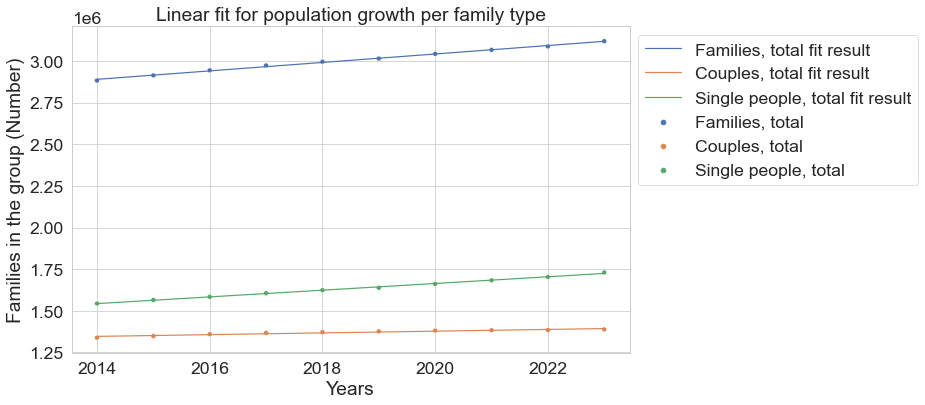

,Family_type,slope,intercept,r_value,p_value,std_err
0,"Families, total",25363.92,-4.82e+07,1.00,3.34e-11,517.80
1,"Couples, total",5225.19,-9.18e+06,0.96,1.22e-05,548.76
2,"Single people, total",20138.72,-3.90e+07,1.00,1.23e-11,362.80


In [22]:
sns.set_context("paper", font_scale=2)  
sns.set_style("whitegrid")

#fig, ax = plt.subplots(1, 2, figsize = (20, 6))
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
#sns.barplot(x = 'year', y = 'Total', hue = 'Family_type', data = Den_tot_df, ax = ax)

#sns.barplot(x = 'year', y = 'Total', hue = 'Family_type', data = Den_tot_df, ax = ax[0])
sns.scatterplot(x = 'year', y = 'Total', hue = 'Family_type', data = Den_tot_df, ax = ax)#[1])

x = np.arange(2014, 2024)
for ftype in Den_tot_df['Family_type'].unique():
    # Retrieve slope and intercept as single values
    slope = fit_df[fit_df['Family_type'] == ftype].slope.values[0]
    intercept = fit_df[fit_df['Family_type'] == ftype].intercept.values[0]
    ax.plot(x, slope * x + intercept, label = f'{ftype} fit result')  # Plot the line
    
plt.xlabel('Years')
plt.ylabel('Families in the group (Number)')
plt.title('Linear fit for population growth per family type')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()
fit_df

The data show us that the data present a linear growth, with a diffrent rate, depending on the cathegory. In particulair we observe that the growth for families is higher than the single and couple.  

The Pearson correlation coefficient and the pvalue whose null hypothesis is that the slope is zero, that the fit is correctly performed. 

### Growth rates percentages 

We now calculate the actual percentage growth rate, year by year, which is the commonly used way to determine the population growth
$$
Growth\,\,rate = \frac{P(t_2)-P(t_1)}{P(t_1)(t_2-t_1)}
$$

We want to determine wheather the different cathegories shows the same growth or if differences can be detected. 

In [23]:
# Total Growth Rate per family type

x = np.arange(2014, 2023)
growth_rates= []

for ftype in Den_tot_df['Family_type'].unique():
    for y in x:
        P1 = Den_tot_df[(Den_tot_df['Family_type'] == ftype)&
                           (Den_tot_df['year'] == y)]
        P2 = Den_tot_df[(Den_tot_df['Family_type'] == ftype)&
                           (Den_tot_df['year'] == y+1)]
        growth_rates.append([ftype, y, (P2['Total'].values[0]-P1['Total'].values[0])*100/P1['Total'].values[0]])


growth_rates_tot_df = pd.DataFrame(growth_rates, columns=['Family_type', 'year', 'growth_rate'])
growth_rates_tot_table = growth_rates_tot_df.pivot(index='Family_type', columns='year', values='growth_rate')

growth_rates_tot_table_perc = growth_rates_tot_table.iloc[:].copy()
for column in growth_rates_tot_table_perc.columns:  # Skip 'Year'
    growth_rates_tot_table_perc[column] = growth_rates_tot_table_perc[column].apply(lambda x: f"{x:.2f}%")

print("Growth Rate per family type summing over each income range group")
growth_rates_tot_table_perc


Growth Rate per family type summing over each income range group


year,2014,2015,2016,2017,2018,2019,2020,2021,2022
Family_type,,,,,,,,,
"Couples, total",0.71%,0.84%,0.57%,0.34%,0.31%,0.34%,0.17%,0.04%,0.32%
"Families, total",1.07%,1.04%,1.00%,0.76%,0.63%,0.93%,0.79%,0.68%,1.02%
"Single people, total",1.38%,1.22%,1.37%,1.10%,0.90%,1.43%,1.30%,1.20%,1.60%


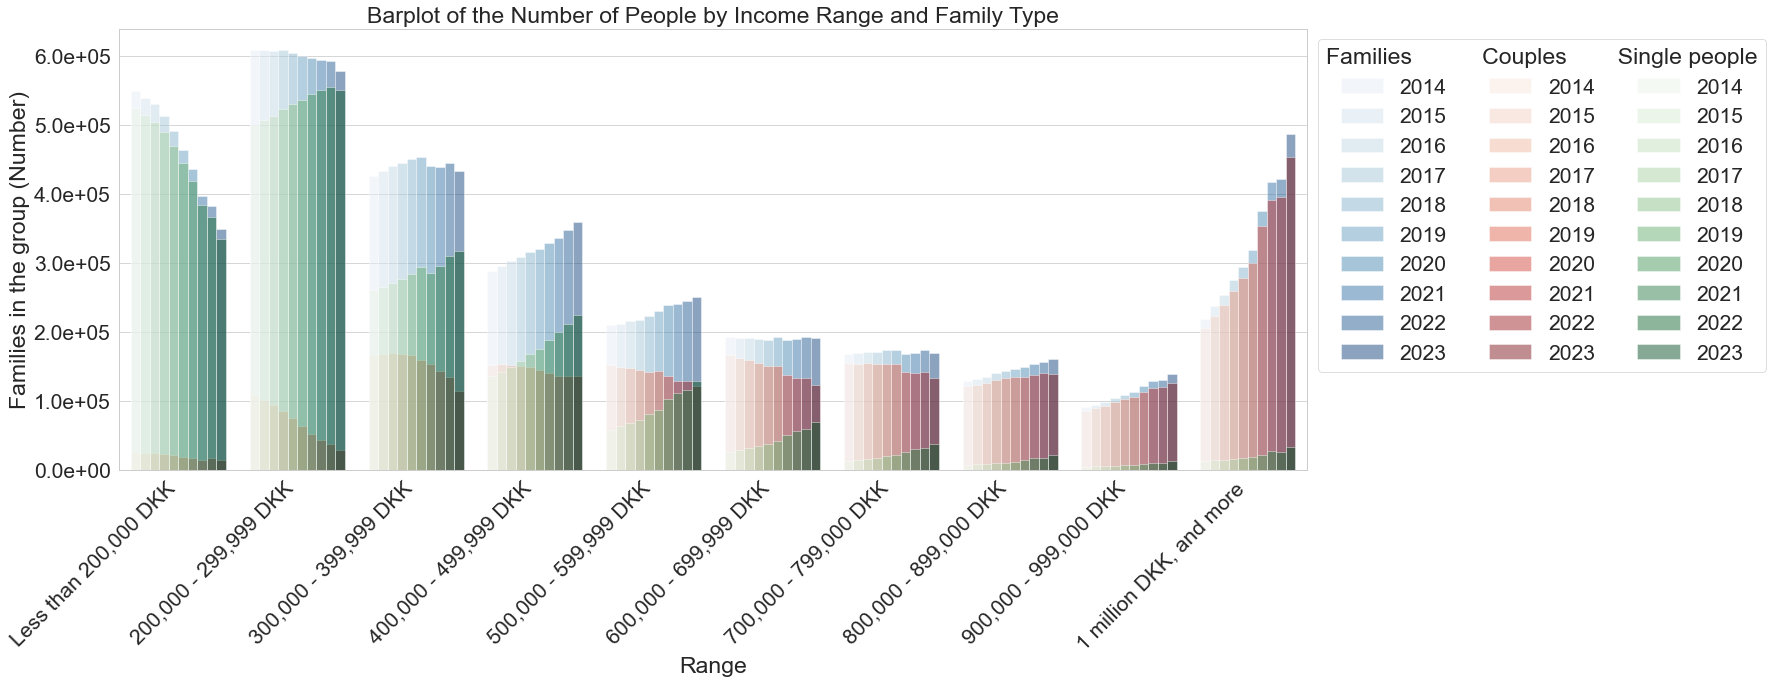

In [24]:
# Creare la figura e gli assi
sns.set_context("paper", font_scale=2.4)  

fig, ax = plt.subplots(figsize=(25, 10))

# Definire diverse palette di colori per ogni family_type
color_palettes = {
    'Families, total': sns.color_palette("Blues", n_colors=len(Den_range_df['year'].unique())),
    'Couples, total': sns.color_palette("Reds", n_colors=len(Den_range_df['year'].unique())),
    'Single people, total': sns.color_palette("Greens", n_colors=len(Den_range_df['year'].unique())),
}

# Lista per raccogliere i gestori della legenda
legend_handles_dict = {}

# Creare un grafico per ogni family_type
for family_type in Den_range_df['Family_type'].unique():
    # Filtrare i dati per la tipologia di famiglia
    df = Den_range_df[Den_range_df['Family_type'] == family_type]

    # Palette di colori per questa tipologia di famiglia
    palette = color_palettes.get(family_type, sns.color_palette("Blues", n_colors=len(Den_range_df['year'].unique())))

    # Creare il grafico a barre
    sns.barplot(x='Range', y='Total', hue='year', data=df, ax=ax, palette=palette, alpha=0.5)

    # Salvare i gestori della legenda (handles) per ogni family_type
    handles, labels = ax.get_legend_handles_labels()
    legend_handles_dict[family_type] = (handles, labels)

    # Modificare le etichette per includere il sottotitolo
    # Aggiungi un sottotitolo alla legenda per ogni family_type
    labels = [f"{label} - {family_type}" for label in labels]

# Personalizzare titolo e altre proprietà del grafico
ax.set_title("Barplot of the Number of People by Income Range and Family Type")
ax.set_xlabel("Range")
ax.set_ylabel("Families in the group (Number)")
plt.xticks(rotation=45, ha='right')

family_types = ['Families', 'Couples', 'Single people']
ax.legend(title= f'{family_types[0]}           {family_types[1]}        {family_types[2]}', bbox_to_anchor=(1, 1), ncol=3)

# Migliorare il layout e mostrare il grafico
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
plt.show()



### Growth Rate distribution

For each group we calculate the annual growth rate in percentage

In [25]:
## table with the different growth rate calculated 
#sns.barplot(x='year', y='Total', hue='Family_type', data=Den_tot_df)
x = np.arange(2014, 2023)
ranges = Den_range_df['Range'].unique()
growth_rates= []

for ftype in Den_range_df['Family_type'].unique():
    for ran in ranges:
        for y in x:
            P1 = Den_range_df[(Den_range_df['Family_type'] == ftype)&
                               (Den_range_df['year'] == y) & (Den_range_df['Range'] == ran)]
            P2 = Den_range_df[(Den_range_df['Family_type'] == ftype)&
                               (Den_range_df['year'] == y+1) & (Den_range_df['Range'] == ran)]
            
            growth_rates.append([ftype,ran, y, (P2['Total'].values[0]-P1['Total'].values[0])*100/P1['Total'].values[0]])


growth_rates_df = pd.DataFrame(growth_rates, columns=['Family_type', 'Range', 'year', 'growth_rate(%)'])

In [26]:
growth_rates_df.head()

,Family_type,Range,year,growth_rate(%)
0,"Families, total","Less than 200,000 DKK",2014,-1.84
1,"Families, total","Less than 200,000 DKK",2015,-1.76
2,"Families, total","Less than 200,000 DKK",2016,-3.23
3,"Families, total","Less than 200,000 DKK",2017,-4.19
4,"Families, total","Less than 200,000 DKK",2018,-5.50


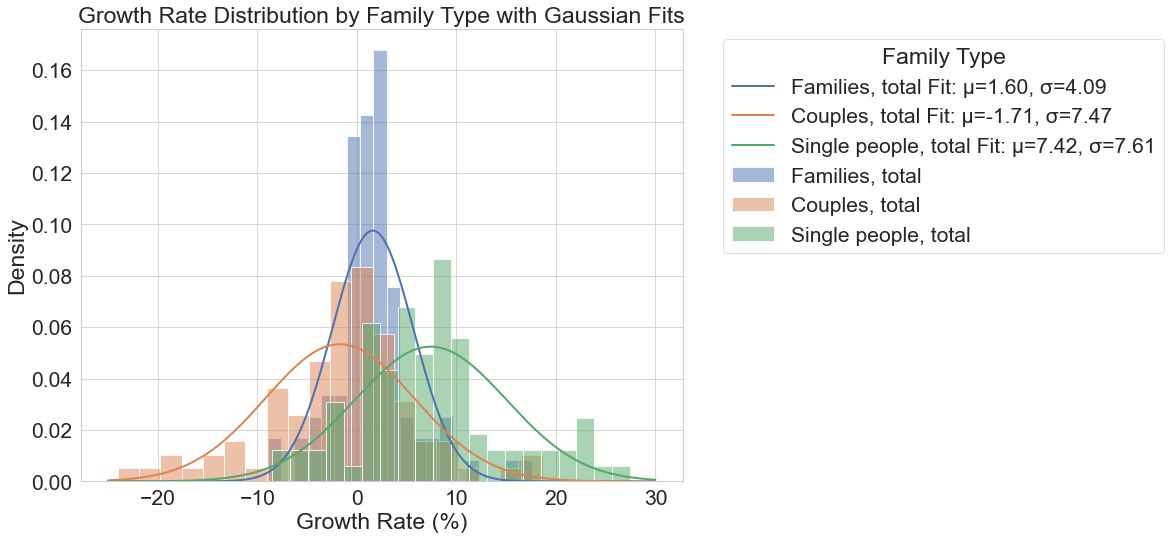

,Family_Type,Mean (μ)(%),Std Dev (σ)(%),KS Statistic,p-value
0,"Families, total",1.60,4.09,0.15,0.03
1,"Couples, total",-1.71,7.47,0.10,0.30
2,"Single people, total",7.42,7.61,0.10,0.27


In [27]:
plt.figure(figsize=(17, 8))

sns.set_style("whitegrid")

color_palettes = {
    'Families, total': sns.color_palette()[0],
    'Couples, total': sns.color_palette()[1],
    'Single people, total': sns.color_palette()[2]
}
fit_results = []

# Loop per tracciare l'istogramma e il fit gaussiano per ciascun gruppo
for idx, family_type in enumerate(growth_rates_df['Family_type'].unique()):
    # Filtra i dati per tipo di famiglia
    data = growth_rates_df[growth_rates_df['Family_type'] == family_type]['growth_rate(%)']

    # Traccia l'istogramma
    sns.histplot(data, bins=20, kde=False, color=color_palettes[family_type], alpha=0.5, label=family_type, stat = 'density')

    # Calcola i parametri del fit gaussiano
    mu, sigma = norm.fit(data)

    # Genera valori per il fit
    x = np.linspace(-25, 30, 1000)
    y = norm.pdf(x, mu, sigma) #* len(data) * (data.max() - data.min()) / 30

    # Traccia il fit gaussiano
    plt.plot(x, y, color=color_palettes[family_type], lw=2, label=f"{family_type} Fit: μ={mu:.2f}, σ={sigma:.2f}")

    # Test di verifica dell'ipotesi
    stat, p_value = kstest(data, 'norm', args=(mu, sigma))
    #print(f"Family Type: {family_type}, KS Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")
    
    fit_results.append({
        'Family_Type': family_type,
        'Mean (μ)(%)': mu,
        'Std Dev (σ)(%)': sigma,
        'KS Statistic': stat,
        'p-value': p_value
    })

# Miglioramento della leggenda
plt.legend(title="Family Type",bbox_to_anchor=(1.05, 1))

# Titoli e etichette
plt.title("Growth Rate Distribution by Family Type with Gaussian Fits")
plt.xlabel("Growth Rate (%)")
plt.ylabel("Density")

# Mostra il grafico
plt.tight_layout()
plt.show()
fit_results_df = pd.DataFrame(fit_results)
fit_results_df

The behaviour described in the barplots above exhibits quite an interesting behaviour. Each group seems to be classified as an indipendent group, each one having a specific constant behaviour over years.
Generally there seems to be a constant growth or decrease for each group.
As we have observede from the discussion on the totality of the groups, the overall behaviour translate in a constant growth for each group, with a different growth rate.

From the graph it seems that we can divide our data in roughly 5 groups:
- high decrease
- low decrease
- constant
- low increase
- high increase



In [28]:
int_ranges = ['Less than 200,000 DKK','1 million DKK, and more','200,000 - 299,999 DKK']

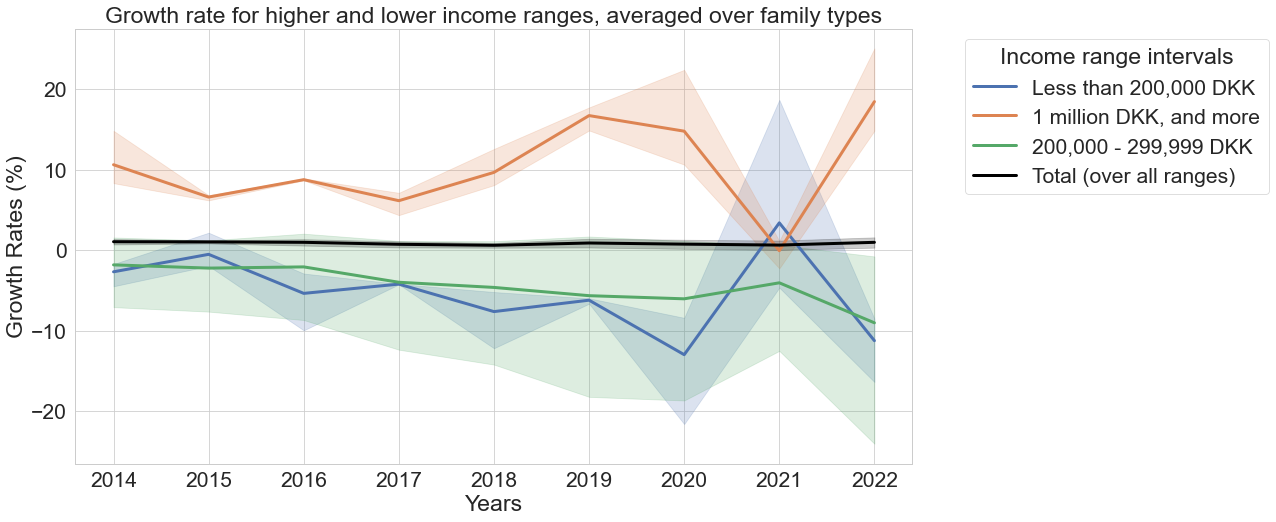

In [29]:
plt.figure(figsize = (15, 8))
int_ranges = ['Less than 200,000 DKK','1 million DKK, and more','200,000 - 299,999 DKK']
for ran in int_ranges:
    sns.lineplot(x = 'year', y = 'growth_rate(%)', data = growth_rates_df[growth_rates_df['Range'] == ran], linewidth = 3, label = ran)
sns.lineplot(x = 'year', y = 'growth_rate', data = growth_rates_tot_df, color = 'black', linewidth = 3, label = 'Total (over all ranges)')
plt.xlabel('Years')
plt.ylabel('Growth Rates (%)')
plt.title('Growth rate for higher and lower income ranges, averaged over family types')
plt.legend(title = 'Income range intervals' , bbox_to_anchor=(1.05, 1))
plt.show()

In [30]:
growth_rates_df[growth_rates_df['year']==2021].groupby(['Range', 'year']).describe()

growth_rate(%)                                  \
                                      count  mean    std    min   25%   50%   
Range                   year                                                  
1 million DKK, and more 2021            3.0 -0.06   1.90  -2.26 -0.66  0.93   
200,000 - 299,999 DKK   2021            3.0 -4.05   7.33 -12.49 -6.39 -0.30   
300,000 - 399,999 DKK   2021            3.0 -0.02   5.49  -6.02 -2.40  1.23   
400,000 - 499,999 DKK   2021            3.0  3.19   2.57   0.46  1.99  3.52   
500,000 - 599,999 DKK   2021            3.0  1.90   2.36  -0.39  0.70  1.79   
600,000 - 699,999 DKK   2021            3.0  1.97   2.38  -0.04  0.66  1.35   
700,000 - 799,000 DKK   2021            3.0  3.01   1.66   1.79  2.06  2.33   
800,000 - 899,000 DKK   2021            3.0  2.77   1.12   2.02  2.13  2.24   
900,000 - 999,000 DKK   2021            3.0  2.02   0.32   1.81  1.84  1.86   
Less than 200,000 DKK   2021            3.0  3.40  13.23  -4.64 -4.24 -3.83   

                                           
                               75%    max  
Range                   year               
1 million DKK, and more 2021  1.04   1.15  
200,000 - 299,999 DKK   2021  0.18   0.65  
300,000 - 399,999 DKK   2021  2.98   4.74  
400,000 - 499,999 DKK   2021  4.55   5.58  
500,000 - 599,999 DKK   2021  3.05   4.32  
600,000 - 699,999 DKK   2021  2.98   4.61  
700,000 - 799,000 DKK   2021  3.62   4.90  
800,000 - 899,000 DKK   2021  3.15   4.06  
900,000 - 999,000 DKK   2021  2.13   2.40  
Less than 200,000 DKK   2021  7.42  18.67

Some observations can be done on this graph. 
Firstly it is possible to observe that the growth rate has remained constant for the all population. However whithin itself the different cathegories have had a different behaviour over the years. 
Here we have divided the graphs depending on the different range of income. 

An interesing observation is that the lower ranges of income have had shown a negative growth rate ove the years, which meant that the number of people in this cathegory have decreased over the time span studied. 

Whereas the higher income group have had a positive growth over the years. 
An interesting observation is that in correspondence to 2021: 
- we observe an increase in the growth rate of the 'Less than 200,000 DKK' group with a positive growth rate of 3.40 % 
- a negative growth rate of -0.06 % for the '1 million DKK, and more	2021'
which may be a consequence of the 2020 Covid-19 Pandemic. 



We select the data related to the different ranges

In [31]:
Den_range_df.head()

,Range,Family_type,place,Total,year
297,"Less than 200,000 DKK","Families, total",All Denmark,549844.0,2014
396,"Less than 200,000 DKK","Couples, total",All Denmark,25633.0,2014
495,"Less than 200,000 DKK","Single people, total",All Denmark,524211.0,2014
594,"200,000 - 299,999 DKK","Families, total",All Denmark,608290.0,2014
693,"200,000 - 299,999 DKK","Couples, total",All Denmark,108840.0,2014


## Income distribution 


In this part we want to focus more on the income distribution.

In economics, there is evidence that the income of 97%–99% of the population is distributed log-normally. Wheras the distribution of higher-income individuals follows a Pareto distribution. 

We evaluate this with a barplot, showing the number of families per income range and distinguishing between the different family types. 

In [32]:
Den_range_df.head()

,Range,Family_type,place,Total,year
297,"Less than 200,000 DKK","Families, total",All Denmark,549844.0,2014
396,"Less than 200,000 DKK","Couples, total",All Denmark,25633.0,2014
495,"Less than 200,000 DKK","Single people, total",All Denmark,524211.0,2014
594,"200,000 - 299,999 DKK","Families, total",All Denmark,608290.0,2014
693,"200,000 - 299,999 DKK","Couples, total",All Denmark,108840.0,2014


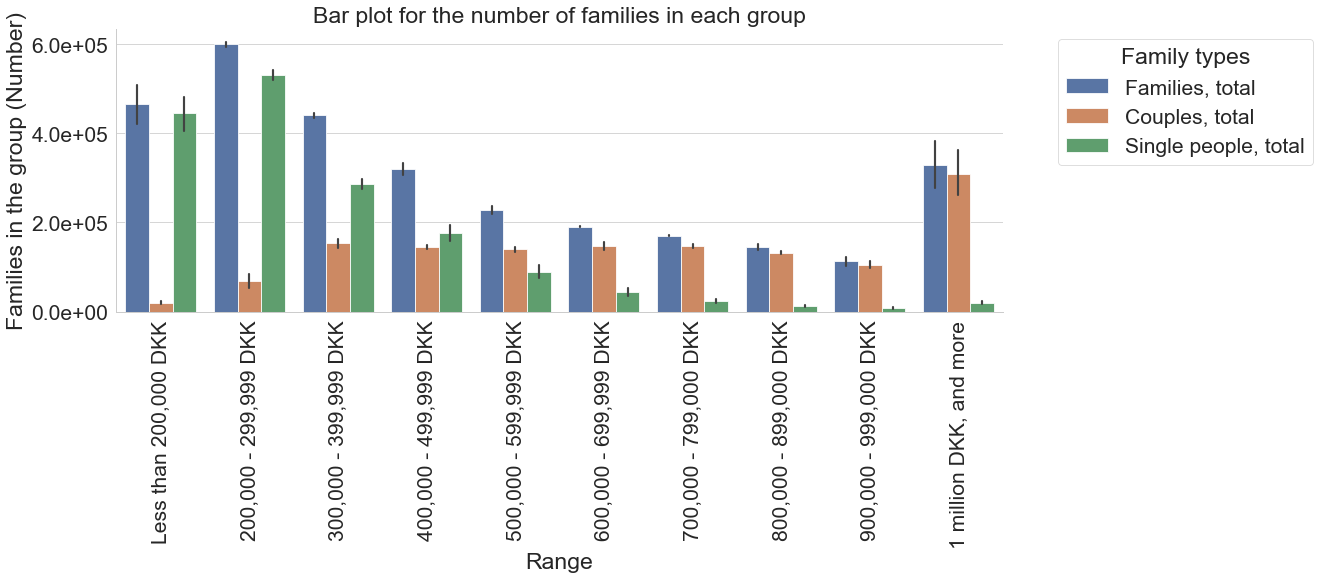

In [33]:
# inserire la percentuale
sns.catplot(x = 'Range', y = 'Total', data = Den_range_df, kind = 'bar', aspect = 3, hue = 'Family_type', legend =False)#, color = 'lightblue')
plt.xlabel('Range')
plt.xticks(rotation = 90)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
plt.title('Bar plot for the number of families in each group')
plt.ylabel('Families in the group (Number)')
plt.legend(bbox_to_anchor=(1.05, 1), title = 'Family types')
plt.show()

The available data are insufficient to perform an actual fit; however, they provide an idea of the general behavior. For families and singles, the data appear to follow an asymmetrical bell-shaped distribution, consistent with the expected characteristics of a log-normal distribution.

This trend is particularly evident for the Singles and Family groups. In the plot, we average the numbers across the years and include error bars to represent variability.

We observe that individuals in the range of 1 million or above deviate from the expected log-normal distribution pattern.

## Analysis per city


In this second part of the notebook we analyse the data related to all cities. Therefore we exclude from the dataset the data related to All Denmark. 

In [34]:
raw_byplace_df = rawdata_df[(rawdata_df['Range'] == 'Total')&(rawdata_df['place'] != 'All Denmark')].groupby('place').sum()
sums = raw_byplace_df.sum(axis=0)
perc_byplace_df = raw_byplace_df.div(sums)*100
perc_byplace_df = perc_byplace_df.sort_values(by = '2014', ascending = False)
perc_byplace_df.head(10)

perc_byplace_df_reformat = perc_byplace_df.iloc[:].copy()
for column in perc_byplace_df_reformat.columns:  # Skip 'Year'
    perc_byplace_df_reformat[column] = perc_byplace_df_reformat[column].apply(lambda x: f"{x:.2f}%")

print("Percentages of number of families per city")
perc_byplace_df_reformat

Percentages of number of families per city


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
place,,,,,,,,,,
Copenhagen,11.93%,12.00%,12.06%,12.14%,12.25%,12.32%,12.40%,12.45%,12.46%,12.46%
Aarhus,6.18%,6.19%,6.23%,6.28%,6.35%,6.42%,6.45%,6.49%,6.55%,6.60%
Aalborg,3.86%,3.86%,3.86%,3.86%,3.88%,3.90%,3.94%,3.95%,3.94%,3.93%
Odense,3.66%,3.67%,3.67%,3.69%,3.71%,3.72%,3.71%,3.70%,3.70%,3.69%
Frederiksberg,2.08%,2.07%,2.06%,2.03%,2.00%,1.98%,1.97%,1.96%,1.96%,1.95%
...,...,...,...,...,...,...,...,...,...,...
Dragør,0.22%,0.22%,0.22%,0.22%,0.22%,0.22%,0.22%,0.22%,0.22%,0.22%
Ærø,0.13%,0.13%,0.12%,0.12%,0.12%,0.12%,0.12%,0.12%,0.11%,0.11%
Samsø,0.07%,0.07%,0.07%,0.07%,0.07%,0.07%,0.07%,0.07%,0.07%,0.07%


In [35]:
perc_byplace_cum_df = perc_byplace_df.cumsum()

perc_byplace_cum_df_reformat = perc_byplace_cum_df.iloc[:].copy()
for column in perc_byplace_cum_df_reformat.columns:  # Skip 'Year'
    perc_byplace_cum_df_reformat[column] = perc_byplace_cum_df_reformat[column].apply(lambda x: f"{x:.2f}%")

In [36]:
print("Cumulative percentages of number of families per city")
perc_byplace_cum_df_reformat.iloc[0:20, :]

Cumulative percentages of number of families per city


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
place,,,,,,,,,,
Copenhagen,11.93%,12.00%,12.06%,12.14%,12.25%,12.32%,12.40%,12.45%,12.46%,12.46%
Aarhus,18.12%,18.19%,18.28%,18.42%,18.60%,18.74%,18.85%,18.94%,19.00%,19.06%
Aalborg,21.97%,22.05%,22.14%,22.29%,22.48%,22.64%,22.79%,22.89%,22.94%,22.99%
Odense,25.63%,25.72%,25.82%,25.97%,26.19%,26.36%,26.50%,26.59%,26.64%,26.68%
Frederiksberg,27.71%,27.80%,27.88%,28.00%,28.19%,28.35%,28.47%,28.55%,28.60%,28.62%
Esbjerg,29.73%,29.81%,29.87%,29.99%,30.16%,30.31%,30.43%,30.50%,30.53%,30.54%
Vejle,31.58%,31.66%,31.73%,31.85%,32.02%,32.18%,32.32%,32.41%,32.45%,32.46%
Randers,33.28%,33.36%,33.43%,33.54%,33.71%,33.86%,33.99%,34.09%,34.14%,34.14%
Viborg,34.86%,34.94%,35.02%,35.12%,35.29%,35.44%,35.57%,35.67%,35.71%,35.71%


From these tables we can observe that the first 20 cities contains the 50% of the population. We take notice that the number of cities for which we have information is 98. 

In [37]:
perc_byplace_cum_df.shape

(98, 10)

In [38]:
perc_byplace_df['place'] = perc_byplace_df.index

In [39]:
df_long = perc_byplace_df.melt(id_vars='place', var_name='year', value_name='percentage')
df_long_filter = df_long[df_long['percentage']> 1.3]

The histplot on the distribution of cities doesn't give us quite a specific understanding of the situation, therefore we calculate and evaluate the poxplot of the log of the total, which may give us a better understanding of the situation and the distribution

In [40]:
Cities_df = Cities_df.replace(0, np.nan)
Cities_df = Cities_df.assign(LogTotal = lambda x : np.log10(x.Total))


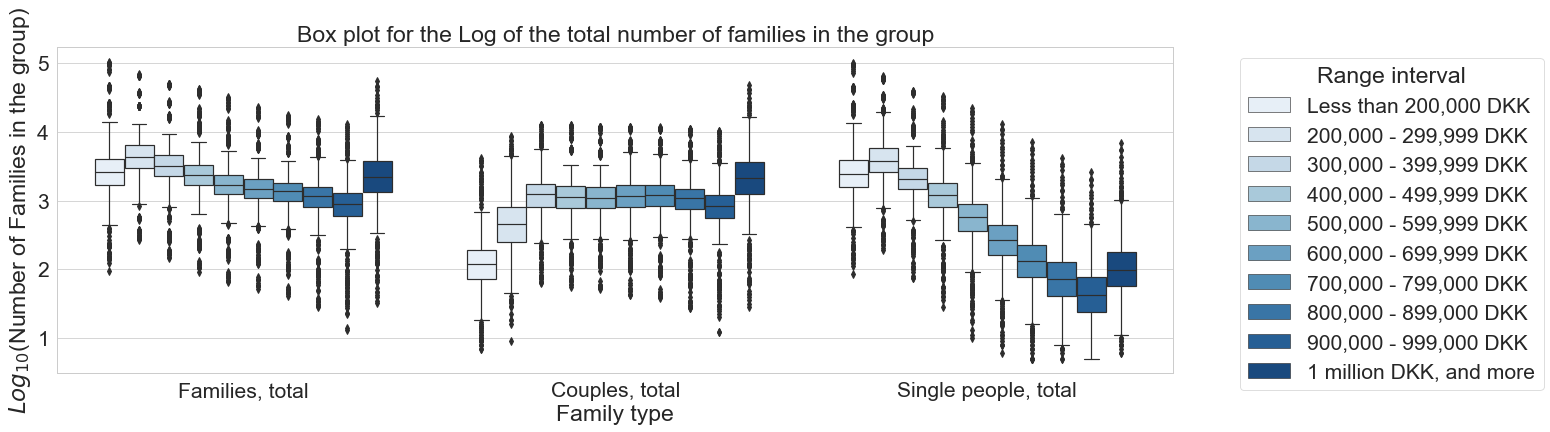

In [41]:
# Plot categorico: boxplot
fig, ax = plt.subplots(figsize=(20, 6))
dat = Cities_df[Cities_df['Range']!= 'Total']
ax=sns.boxplot(data=dat, x="Family_type", y="LogTotal", hue="Range", palette="Blues")
ax.set_xticklabels(ax.get_xticklabels())
ax.set_xlabel("Family type")
ax.set_ylabel(r"$Log_{10} $(Number of Families in the group)")
ax.set_title('Box plot for the Log of the total number of families in the group')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title = 'Range interval')
plt.show()

This box plot is quite interesting, as it reveals groups of data that show very similar behavior, while others deviate.

Overall, the box plot confirms the hypothesis that different groups among the cities exhibit different behaviors. Additionally, as expected, there is a significant amount of outliers.

## Distribution of city sizes 

By summing together the number of people per family type and income range, we are able to determine the number of families per city. 
This value may give us an idea of the size of the cities in Denmark. 

City sizes, in terms of population follow Gibrat's Law, which states that the growth process of city sizes is proportional and invariant with respect to the size of the city. According to the central limit theorem, this implies that the logarithm of city sizes is normally distributed.

In [42]:
Cities_df.head()

,Range,Family_type,place,Total,year,LogTotal
1,Total,"Families, total",Copenhagen,343970.0,2014,5.54
2,Total,"Families, total",Frederiksberg,60036.0,2014,4.78
3,Total,"Families, total",Dragør,6464.0,2014,3.81
4,Total,"Families, total",Tårnby,20869.0,2014,4.32
5,Total,"Families, total",Albertslund,13811.0,2014,4.14


Kolmogorov-Smirnov test for normal distribution
KS Statistic: 0.07909745292620562, p-value: 1.9068888432044199e-16
Kolmogorov-Smirnov test for Cauchy distribution:
KS Statistic: 0.05843602198405051, p-value: 3.614057519591142e-09


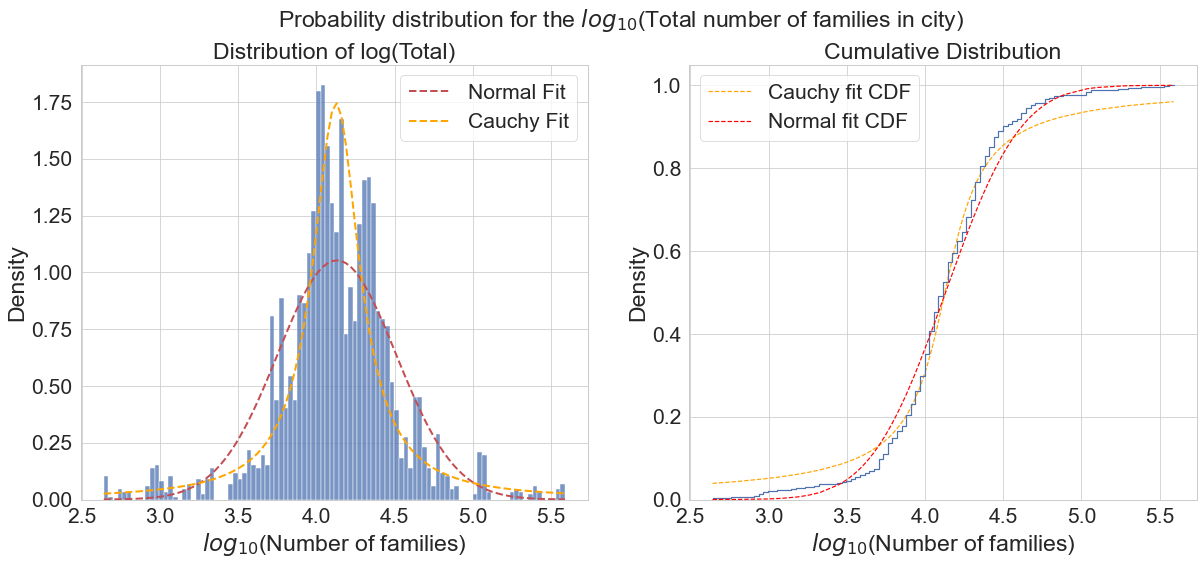

,Statistic,Value
0,Variance,0.14
1,Skewness,-0.27
2,Kurtosis,2.74


In [55]:
# Performing the fit
values = Cities_df[Cities_df['Range'] == 'Total']['LogTotal'].values

'''
Normal distribution fit 
'''
mu_norm, std_norm  = norm.fit(values)

# Perform Kolmogorov-Smirnov test
ks_stat_norm, p_value_norm = kstest(values, 'norm', args=(mu_norm, std_norm))
print(f"Kolmogorov-Smirnov test for normal distribution")
print(f"KS Statistic: {ks_stat_norm}, p-value: {p_value_norm}")

mu_cauchy, std_cauchy  = cauchy.fit(values)

# Perform Kolmogorov-Smirnov test
ks_stat_cauchy, p_value_cauchy = kstest(values, 'cauchy', args=(mu_cauchy, std_cauchy))
print(f"Kolmogorov-Smirnov test for Cauchy distribution:")
print(f"KS Statistic: {ks_stat_cauchy}, p-value: {p_value_cauchy}")


# calculation of statistical quantities 
skewness = stats.skew(values)
variance = np.var(values)
kurt = stats.kurtosis(values)


KS_results = {
    'Statistic': ['KS Statistic', 'p-value'],
    'Normal distribution': [ks_stat_norm, p_value_norm],
    'Cauchy distribution': [ks_stat_cauchy, p_value_cauchy],
}
stat_results = {
    'Statistic': ['Variance','Skewness',  'Kurtosis'],
    'Value': [variance, skewness, kurt]}

KS_results_df = pd.DataFrame(KS_results)
stat_results_df = pd.DataFrame(stat_results)




'''
graphical representation
'''
fig, ax = plt.subplots(1, 2, figsize = ( 20, 8))

fig.suptitle(r'Probability distribution for the $log_{10}$(Total number of families in city)', fontsize = 23)
# plot 1 : distribution of the log of the number of people per city
sns.histplot(Cities_df[Cities_df['Range'] == 'Total'], x = 'LogTotal',  multiple = 'stack', stat = 'density', ax = ax[0], bins = 100)# hue = 'Family_type',
x = np.linspace(min(values), max(values), 100)
ax[0].plot(x, norm.pdf(x, mu_norm, std_norm), 'r--', linewidth=2, label = 'Normal Fit')
ax[0].plot(x, cauchy.pdf(x, mu_cauchy, std_cauchy), 'r--', linewidth=2, label = 'Cauchy Fit', color = 'orange')
ax[0].set_title('Distribution of log(Total)')
ax[0].set_xlabel(r'$log_{10}$(Number of families)')
ax[0].legend()

# Cumulative distribution function (CDF)
x = np.sort(values)
cdf_norm = norm.cdf(x, loc=mu_norm, scale=std_norm)
cdf_cauchy = cauchy.cdf(x, loc=mu_cauchy, scale=std_cauchy)

ax[1].plot(x, cdf_cauchy, label='Cauchy fit CDF', linestyle='--', color = 'orange')
sns.histplot(Cities_df[Cities_df['Range'] == 'Total'], x='LogTotal',  multiple='stack', cumulative=True, stat='density', element='step', fill=0, ax = ax[1], bins = 100)
ax[1].plot(x, cdf_norm, label='Normal fit CDF', linestyle='--', color = 'red')
ax[1].legend()
ax[1].set_xlabel(r'$log_{10}$(Number of families)')

ax[1].set_title('Cumulative Distribution')
plt.show()
stat_results_df



The results of the Kolmogorov-Smirnov test allow us to reject the null hypothesis that the distribution is normally distributed. Consequently, we cannot confirm that the distribution of city sizes follows a lognormal distribution. It is important to emphasize that we are not directly analyzing the sizes of the cities themselves but rather the distribution of contributors. Additionally, the numbers we are considering do not represent individual people; for instance, the number of couples corresponds to twice the number of individuals.

A symmetric distribution has a skewness value close to 0, which is the case in our analysis. The kurtosis analysis yields a value greater than 0, indicating a leptokurtic distribution. This suggests that the distribution deviates from normality and has heavier tails.

## Gini coefficient calculation

In economics, the Gini coefficient is a measure of statistical dispersion intended to represent the income inequality, the wealth inequality, or the consumption inequality within a nation or a social group. It was developed by Italian statistician and sociologist Corrado Gini.

The Gini coefficient measures the inequality among the values of a frequency distribution, such as levels of income. A Gini coefficient of 0 reflects perfect equality, where all income or wealth values are the same, while a Gini coefficient of 1 (or 100%) reflects maximal inequality among values. 

The Gini coefficient is usually defined mathematically based on the Lorenz curve, which plots the proportion of the total income of the population (y-axis) that is cumulatively earned by the bottom x of the population. The line at 45 degrees thus represents perfect equality of incomes. The Gini coefficient can then be thought of as the ratio of the area that lies between the line of equality and the Lorenz curve

We try to evaluate it, by uploading also the data related to the total and average income per income range group. 

We upload this data on raw_income_amount_data_df. 

In [44]:
file_name = 'Total_and_average_income_dk_2014-2023.csv'

In [45]:
columns = ['Place', 'Income_type', 'Family_type', 'Range', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

In [46]:
raw_income_amount_data_df = pd.read_csv(file_name, sep=',', header = None)
raw_income_amount_data_df.columns = columns
raw_income_amount_data_df = raw_income_amount_data_df.drop(columns = 'Place')
raw_income_amount_data_df.head()

,Income_type,Family_type,Range,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Amount of income (DKK 1.000),"Families, total",Total,1386300068,1441886008,1473380816,1523436324,1561490380,1627476540,1712906508,1806748661,1823458241,1958866915
1,Amount of income (DKK 1.000),"Families, total","Less than 200,000 DKK",65753967,66246107,63417356,61178874,57394915,54929951,50912742,46969276,40357909,37599754
2,Amount of income (DKK 1.000),"Families, total","200,000 - 299,999 DKK",149190580,149495716,149119806,149950587,148989062,148283119,147939157,147549098,147793455,145893301
3,Amount of income (DKK 1.000),"Families, total","300,000 - 399,999 DKK",148050122,150678748,152796425,154313776,156537827,157665142,153302003,153183083,155393910,151315928
4,Amount of income (DKK 1.000),"Families, total","400,000 - 499,999 DKK",128954784,131841235,134929901,137707814,141475212,143382448,147056765,150409738,155582832,161041354


In [47]:
dic_rename = {
    '1 million DKK, and more': 'Over 1M DKK',
    '200,000 - 299,999 DKK': '200K-299K DKK',
    '300,000 - 399,999 DKK': '300K-399K DKK',
    '400,000 - 499,999 DKK': '400K-499K DKK',
    '500,000 - 599,999 DKK': '500K-599K DKK',
    '600,000 - 699,999 DKK': '600K-699K DKK',
    '700,000 - 799,000 DKK': '700K-799K DKK',
    '800,000 - 899,000 DKK': '800K-899K DKK',
    '900,000 - 999,000 DKK': '900K-999K DKK',
    'Less than 200,000 DKK': '0K-200K DKK',
    'Total': 'Total Income'
}

We group by Range and rename the ranges data. 

In [48]:
income_byrange_df = raw_income_amount_data_df.groupby(['Range']).sum()
income_byrange_df = income_byrange_df.rename(dic_rename)
income_byrange_df = income_byrange_df.sort_values(by = 'Range')
income_byrange_df = income_byrange_df.iloc[0:-1]

We calculate the cumulative values for population and total income per year and per income range, and then determine the Gini coefficient.

In [49]:
# cumulative and normalization
income_cum_df = income_byrange_df.cumsum( axis=0)
normalized_income_cum_df = income_cum_df.div(income_cum_df.iloc[-1, :], axis=1)*100

In [50]:
# population by range
pop_byrange_df = rawdata_df[rawdata_df['place'] == 'All Denmark'].groupby(['Range']).sum()
pop_byrange_df = pop_byrange_df.rename(dic_rename)
pop_byrange_df = pop_byrange_df.sort_values(by = 'Range')
pop_byrange_df = pop_byrange_df.iloc[0:-1]

In [51]:
# cumulative and normalization
pop_cum_df = pop_byrange_df.cumsum()
normalized_pop_cum_df = pop_cum_df.div(pop_cum_df.iloc[-1, :], axis=1)*100

We define this function to estimate the Gini coefficient by calculating the area under the Lorenz curve using the trapezoidal rule (the trapz method).

In [52]:
def gini_index(df):
    # Aggiungiamo la colonna per i valori cumulativi
    df = df.sort_values('Cumulative_Population')  # Assicuriamoci che i dati siano ordinati
    df['Cumulative_Population'] = df['Cumulative_Population'] / 100  # Normalizziamo tra 0 e 1
    df['Cumulative_Income'] = df['Cumulative_Income'] / 100  # Normalizziamo tra 0 e 1

    # Calcolare l'area sotto la curva di Lorenz (usando il metodo dei trapezi)
    area_under_lorenz = np.trapz(df['Cumulative_Income'], df['Cumulative_Population'], dx =0.01)

    # Calcolare l'indice di Gini
    gini = (1 - 2 * area_under_lorenz )*100
    return gini

In [53]:
Lorenz_data = []
ginis = []
for year in pop_cum_df.columns:
    
    x = normalized_pop_cum_df[year]
    y = normalized_income_cum_df[year]

    Lorenz_df = pd.concat([x, y], axis = 1)
    Lorenz_df.columns = ['Cumulative_Population', 'Cumulative_Income']
    ginis.append([year,gini_index(Lorenz_df)])
    Lorenz_df['year'] = year
    Lorenz_data.append(Lorenz_df)
Lorenz_data_df = pd.concat(Lorenz_data)
ginis_df = pd.DataFrame(ginis, columns = ['year', 'Gini(%)'])  


In [54]:
ginis_df.set_index('year').T

year,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Gini(%),40.78,41.18,41.09,41.16,40.9,41.05,41.08,41.03,40.9,41.07


The estimation of the Gini coefficient gives us a value of approximately 41%. According to data from the Denmark Statistics Institute, the Gini coefficient for Denmark was around 28.2% in 2023. Our estimation differs, which may be due to the fact that the available data was distributed in wide income ranges of 100K DKK.

Additionally, the approximation of the coefficient was performed using the trapezoidal method to calculate the integral, which is subject to errors.

In general, poor countries (those with low per-capita GDP) have Gini coefficients that range from low (0.25) to high (0.71), while rich countries typically have lower Gini coefficients (under 0.40). 

The european mean was of 29.6 % in 2023. 




# Conclusioni
Denmark is a wealthy country with notable differences in income distribution among various family types. The distribution of city sizes reveals interesting patterns.
The sizes of cities are sparse, and the distribution does not follow the Gibrat's Law. 

Although the impact of COVID-19 became evident in 2021, it does not appear to have caused a long-term negative trend. This resilience may be attributed to specific policy decisions, the relatively low impact of the pandemic in Denmark, the country’s small population, or its unique cultural context.

An other interesting reflection that can be done when looking at our results is that data segmentation is essential for understanding complex trends. By dividing information into subcategories, valuable insights can be uncovered that might otherwise remain hidden.